In [1]:
#I am redoing this notebook since I lost it. 
# Reminder: Push to github more often, specialy when working on your old computer

from datasets import load_dataset
import pandas as pd
import torch
import torch.nn.functional as F
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

#Loading the environment variables
load_dotenv() 

PROJECT_DIR = os.getenv("PROJECT_DIR")
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Fine-tuning transformer model

In [2]:
# loading the pretrained model, we are using AutoModelForSequenceClassification and not AutoModel
# because we are interested in the classification head of the model
#!!! Notice that the classification head is randomly initialized

num_labels = 6
model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Let's re-load the emotions dataset
#Tokenizing the whole dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

#Load back the emotions dataset
emotions = load_dataset("emotion", trust_remote_code=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [4]:
# metrics function for the Trainer

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1
    }

In [6]:
# log in to the huggingface hub
notebook_login()

In [7]:
#let's define the training arguments and the trainer

batch_size = 65
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"
training_args = TrainingArguments(
    output_dir= os.path.join(PROJECT_DIR, "data/models", model_name),
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level='error',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

# training the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.854000,0.323731,0.906500,0.905536
2,0.261600,0.218473,0.924500,0.924375


TrainOutput(global_step=494, training_loss=0.5565101460889283, metrics={'train_runtime': 135.9175, 'train_samples_per_second': 235.437, 'train_steps_per_second': 3.635, 'total_flos': 720342861696000.0, 'train_loss': 0.5565101460889283, 'epoch': 2.0})

In [8]:
# Here I did not understand why one needs to pass the tokenizer to the trainer, and how does the trainer
# knows which columns from the dataset to use for the input and the labels.

'''
From this page: https://huggingface.co/docs/transformers/main_classes/trainer

-  tokenizer (PreTrainedTokenizerBase, optional) — The tokenizer used to preprocess the data. 
If provided, will be used to automatically pad the inputs to the maximum length when batching inputs, 
and it will be saved along the model to make it easier to rerun an interrupted training or reuse the fine-tuned model. 

From this page: https://huggingface.co/docs/transformers/main_classes/model

- main_input_name (str) — The name of the principal input to the model (often input_ids for NLP models, pixel_values for 
vision models and input_values for speech models).

From this page: https://huggingface.co/docs/transformers/main_classes/tokenizer

-  model_input_names (List[string], optional) — The list of inputs accepted by the forward pass of the model 
(like "token_type_ids" or "attention_mask"). Default value is picked from the class attribute of the same name. 

'''

# Looks like the tokenizer is not needed as long as the dataset has the right columns, already tokenized
# Also looks like the tokenizer and the model already have defined the names of the input columns they expect

print(tokenizer.model_input_names)
print(model.main_input_name)

#It is strange that one must pre-tokenize the dataset and then pas it to the trainer
# I tried to pass the original dataset and the tokenizer and it throws an error. 
# Maybe in next chapters we will be able to stack the tokenizer and the model in a pipeline (???)


['input_ids', 'attention_mask']
input_ids


{'test_loss': 0.21847280859947205, 'test_accuracy': 0.9245, 'test_f1': 0.9243745020399392, 'test_runtime': 2.0104, 'test_samples_per_second': 994.809, 'test_steps_per_second': 15.42}


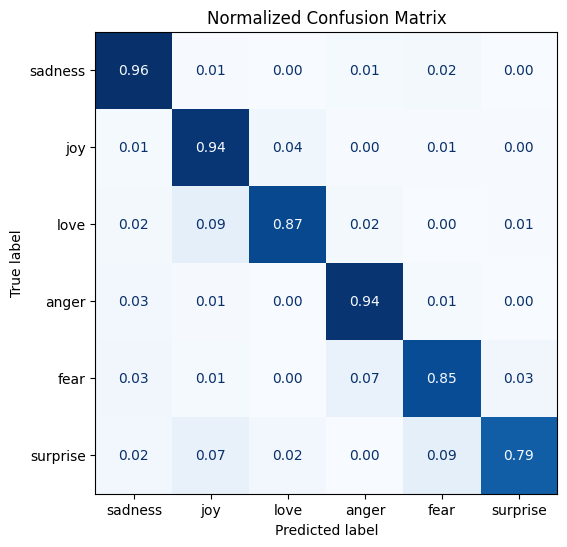

In [9]:
#plot confusion matrices
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()


# Let's displa the predictions
preds_output = trainer.predict(emotions_encoded['validation'])
print(preds_output.metrics)

# The predictions are logits!!!
labels = emotions['train'].features['label'].names
y_valid = emotions_encoded['validation']['label']
y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels)


### Error Analysis

In [10]:
def forwar_pass_with_label(batch):
    # all tensors are moved to the device
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names} # here we cans ee the model_input_names

    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(F.softmax(outputs.logits, dim=1), dim=1)
        loss = F.cross_entropy(outputs.logits, batch['label'].to(device), reduction='none')

    # we return the loss and the predicted labels to cpu 
    return {'loss': loss.cpu().numpy(), 'pred_label': pred_label.cpu().numpy()}

# Convert dataset to pytoech tensors
emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Let's compute the loss and the predicted labels for the validation set
emotions_encoded['validation'] = emotions_encoded['validation'].map(forwar_pass_with_label,
                                                                    batched=True,
                                                                    batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
def label_int2str(idx): # renamed row with idx, since we are passing single value from each row, 'label' column
    return emotions['train'].features['label'].int2str(idx)

# Create a dataframe
emotions_encoded.set_format(type='pandas')
cols = ['text', 'label', 'pred_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['pred_label'] = df_test['pred_label'].apply(label_int2str)

#Goals of this error analysis:
# 1. Detect wrong or ambiguous labels (sort top biggest losses)
# 2. Detect quirks of the dataset (sort top biggest losses)
# 3. Detect shortcuts or trivial solutions the model might have learned (sort top smallest losses)

In [12]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,pred_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.670861
1963,i called myself pro life and voted for perry w...,joy,sadness,5.364862
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.345907
1801,i feel that he was being overshadowed by the s...,love,sadness,5.259967
1950,i as representative of everything thats wrong ...,surprise,sadness,5.117862
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.985904
1662,i did not directly react to the spot fixing co...,joy,anger,4.663609
1683,i had applied for a job and they had assured m...,anger,joy,4.660645
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.630473
465,i would eventually go in to these stores but i...,joy,fear,4.528760


In [13]:
df_test.sort_values('loss', ascending=True).head(10)

,text,label,pred_label,loss
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.018203
392,i remember feeling disheartened one day when w...,sadness,sadness,0.018456
69,i have no extra money im worried all of the ti...,sadness,sadness,0.018550
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.018574
1310,i feel like an ungrateful asshole,sadness,sadness,0.018708
869,i dont have training to count on to see the gi...,sadness,sadness,0.018716
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.018731
1303,i feel pathetic and uninspired,sadness,sadness,0.018895
1965,i started feeling pathetic and ashamed,sadness,sadness,0.018964
34,i feel that i m so pathetic and downright dumb...,sadness,sadness,0.018970


### Saving and sharing the model

In [14]:
# push the model to the huggingface model hub
# I do not understand why we need to push the model to the hub, since we are already pushing it in the Trainer
# when we set the push_to_hub=True ???

trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/PolLM/distilbert-base-uncased-finetuned-emotions/commit/0bff64c0ba755fcac70fa84937dfc40e34aa8bed', commit_message='Training completed!', commit_description='', oid='0bff64c0ba755fcac70fa84937dfc40e34aa8bed', pr_url=None, pr_revision=None, pr_num=None)


When pushing the model tot he hub, it automatically creates a Model  Card with information about the loss, tracking metrics, model parameters and results. Very nice!!!

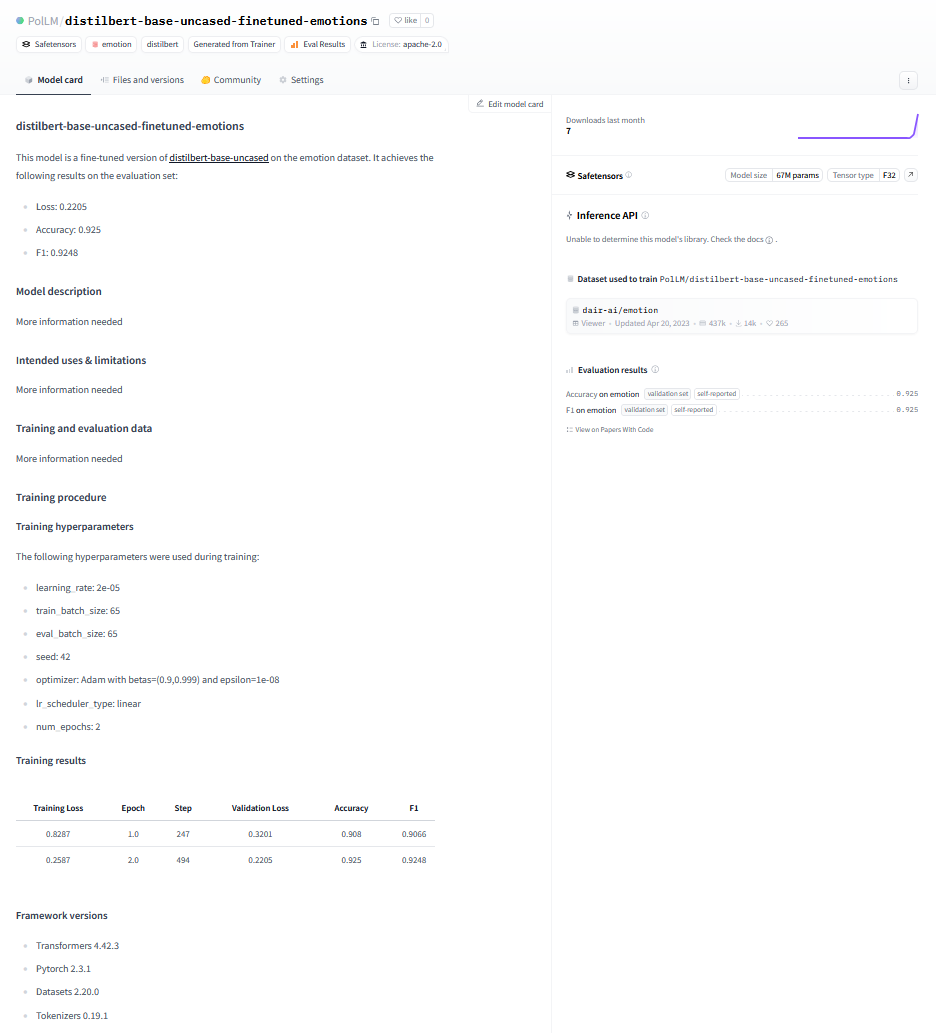

In [15]:
#Let's load the model from the hub
# looks like that when pulling from the hub the tokenizer is already included in the model
# this may be a good reason to add the tokenizer to the model when training
model_id = "PolLM/distilbert-base-uncased-finetuned-emotions"
classifier = pipeline('text-classification', model=model_id)



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

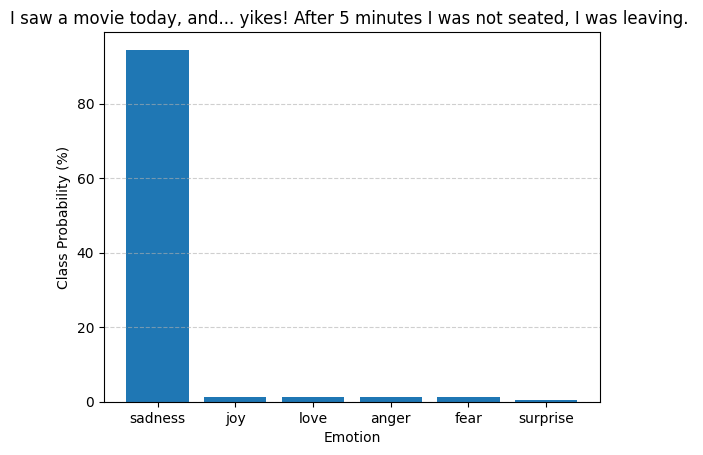

In [18]:
#Let's test the model!!!!

custom_tweet = "I saw a movie today and it was really good!"
#let's make it more difficult (to be fair the emotion disappointment is not a class in the dataset), it fails by predicting Joy :'(
custom_tweet_2 = "I saw a movie today, and... yikes! After 5 minutes I was not seated, I was leaving. "

# Here I changed the top_k to None, since the other method was deprecated
preds = classifier(custom_tweet, top_k=None)
preds_df = pd.DataFrame(preds)
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.title(f"{custom_tweet_2}")
plt.ylabel('Class Probability (%)')
plt.xlabel('Emotion')
plt.grid(axis='y' , linestyle='--', alpha=0.6)
plt.show()